# Wine Type Prediction
<img src="https://media.licdn.com/dms/image/D5612AQHwzFJW75X22A/article-cover_image-shrink_720_1280/0/1674384291032?e=2147483647&v=beta&t=DNv1zn1laHsZYz-z_6iCxj304QcfFMrikPrX_fBUzSQ">
<br>


- [The Wine Type Prediction dataset](https://archive.ics.uci.edu/ml/datasets/Wine) consists of data related to the chemical properties of various wines and classifies each wine into on1 of 3 possible classes. The columns in the dataset are as follows:

|col name|description|
|:--|:--|
|target| This is the target variable to be predicted. There are three possible classes, class 1, 2 and 3 |
|alcohol| continuous | 
|malic_acid| continuous | 
|ash| continuous | 
|alcalinity_of_ash| continuous |    
|magnesium| continuous | 
|total_phenols| continuous | 
|flavanoids| continuous | 
|nonflavanoid_phenols| continuous | 
|proanthocyanins| continuous | 
|color_intensity| continuous | 
|hue| continuous | 
|od280/od315_of_diluted_wines| continuous | 
|proline| continuous | 


- The goal of this project is to build and tune a model to predict the `target` column using AWS Sagemaker and deploy the model as a `Serverless Inference Endpoint`

<a id="table_content"></a>

## Table of Content
- **[1 | Import Libraries](#l)**
- **[2 | Dataset Preparation](#2)**
- **[3 | Dataset Overview](#3)**
    - **[3.1 | Summary Statistics](#3.1)**
- **[4 | Univariate Analysis](#4)**
- **[5 | Bivariate Analysis](#5)**
- **[6 | Data Preprocessing](#6)**
    - **[6.1 | Missing Value Treatment](#6.1)**
    - **[6.2 | Duplicate Values Treatment](#6.2)**
    - **[6.3 | Outlier Treatment](#6.3)**
    - **[6.4 | Split out training and testing datasets](#6.4)**
    - **[6.5 | Write the training and testing datasets to S3](#6.5)**
- **[7 | Model Deployement Process](#7)**
    - **[7.1 | Fit the Pipeline](#7.1)**
    - **[7.2 | Check the training job name](#7.2)**
    - **[7.3 | Hyperparameter Tuning](#7.3)**
- **[8 | Serverless Deployment](#8)**
    - **[8.1 | Invoke the Model](#8.1)**
    - **[8.2 | Clean up](#8.2)**

<div style="background-color:#ffcccb; border:1px solid red; padding:12px; border-radius:12px"><b>📝 Note:</b> Due to AWS console charges, I have shut down my AWS SageMaker. Please test this notebook in your AWS SageMaker environment.</div>

# 1 | Import Libraries
<a id="1"></a>
 ⬆️[Table Contents](#table_content)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

import ppscore as pps

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline


# 2 | Dataset Preparation
<a id="2"></a>
 ⬆️[Table Contents](#table_content)

In [2]:
cols = [
    "target",
    "alcohol", 
    "malic_acid", 
    "ash", 
    "alcalinity_of_ash",    
    "magnesium", 
    "total_phenols", 
    "flavanoids", 
    "nonflavanoid_phenols", 
    "proanthocyanins", 
    "color_intensity", 
    "hue", 
    "od280/od315_of_diluted_wines", 
    "proline"
]

In [3]:
wine_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", names=cols)

print(wine_df.shape)
wine_df.head()

(178, 14)


,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# 3 | Dataset Overview
<a id="3"></a>
 ⬆️[Table Contents](#table_content)

In [4]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   target                        178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  od280/od315_of_diluted_wines  178 non-null    float64
 13  proli

<div style="background-color: #bca89f; padding: 20px; border-radius: 10px;">
  <h2 style="text-align: center;">🍷 Inferences 🍷</h2>
  <p><strong>Number of Entries:</strong> The dataset consists of 178 entries, ranging from index 0 to 177.</p>
  <p><strong>Columns:</strong> There are 14 columns in the dataset corresponding to various attributes.</p>
  <p><strong>Data Types:</strong> Most of the columns (11 out of 14) are of the float64 data type. columns like target, magnesium, proline are of the  int64 data type.</p>
  <p><strong>Missing Values:</strong> There don't appear to be any missing values in the dataset as each column has 178 non-null entries.</p>
</div>


## 3.1 | Summary Statistics
<a id="3.1"></a>

In [5]:
wine_df.drop(columns=['target']).describe().T

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


<div style="background-color: #bca89f;  padding: 20px; border-radius: 10px;">
  <h2 style="text-align: center;">🍷 Inferences 🍷</h2>
  <p><strong>Alcohol:</strong> The mean alcohol content is approximately 13.00%, with a standard deviation of 0.81%. It ranges from 11.03% to 14.83%, indicating variability in alcohol levels.</p>
  <p><strong>Malic Acid:</strong> The mean malic acid content is around 2.34 g/l, with a standard deviation of 1.12 g/l. It ranges from 0.74 g/l to 5.80 g/l, suggesting variation in acidity levels.</p>
  <p><strong>Ash:</strong> The mean ash content is approximately 2.37 g, with a standard deviation of 0.27 g. It ranges from 1.36 g to 3.23 g, indicating variability in mineral content.</p>
  <p><strong>Alcalinity of Ash:</strong> The mean alcalinity of ash is around 19.49 mEq/l, with a standard deviation of 3.34 mEq/l. It ranges from 10.60 mEq/l to 30.00 mEq/l, indicating varying levels of alkalinity.</p>
  <p><strong>Magnesium:</strong> The mean magnesium content is approximately 99.74 mg/l, with a standard deviation of 14.28 mg/l. It ranges from 70.00 mg/l to 162.00 mg/l, suggesting variability in mineral composition.</p>
  <p><strong>Total Phenols:</strong> The mean total phenols content is approximately 2.30 mg/g, with a standard deviation of 0.63 mg/g. It ranges from 0.98 mg/g to 3.88 mg/g, indicating a range of phenolic compounds.</p>
  <p><strong>Flavanoids:</strong> The mean flavanoids content is around 2.03 mg/g, with a standard deviation of 1.00 mg/g. It ranges from 0.34 mg/g to 5.08 mg/g, suggesting a diversity in flavanoid composition.</p>
  <p><strong>Nonflavanoid Phenols:</strong> The mean nonflavanoid phenols content is approximately 0.36 mg/g, with a standard deviation of 0.12 mg/g. It ranges from 0.13 mg/g to 0.66 mg/g, indicating variations in non-flavanoid phenolic compounds.</p>
  <p><strong>Proanthocyanins:</strong> The mean proanthocyanins content is around 1.59 mg/g, with a standard deviation of 0.57 mg/g. It ranges from 0.41 mg/g to 3.58 mg/g, indicating a range of proanthocyanin levels.</p>
  <p><strong>Color Intensity:</strong> The mean color intensity is approximately 5.06, with a standard deviation of 2.32. It ranges from 1.28 to 13.00, suggesting a wide range of color intensities in the wines.</p>
  <p><strong>Hue:</strong> The mean hue value is around 0.96, with a standard deviation of 0.23. It ranges from 0.48 to 1.71, indicating variability in color shades and potentially the maturity of the wines.</p>
  <p><strong>OD280/OD315 of Diluted Wines:</strong> The mean OD280/OD315 value is approximately 2.61, with a standard deviation of 0.71. It ranges from 1.27 to 4.00, suggesting variations in the optical density and potentially the concentration of wine compounds.</p>
  <p><strong>Proline:</strong> The mean proline content is around 746.89 mg/l, with a standard deviation of 314.91 mg/l. It ranges from 278.00 mg/l to 1680.00 mg/l, indicating variability in proline levels.</p>
</div>


In [6]:
wine_df['target'].value_counts()

2    71
1    59
3    48
Name: target, dtype: int64

<div style="background-color: #bca89f;  padding: 20px; border-radius: 10px;">
  <h2 style="text-align: center;">🍷 Wine Target Distribution 🍷</h2>
  <p>The dataset contains information on the target variable, which represents different types of wine. Here's the distribution:</p>
  <ul>
    <li><strong>Wine Type 2:</strong> 71 entries</li>
    <li><strong>Wine Type 1:</strong> 59 entries</li>
    <li><strong>Wine Type 3:</strong> 48 entries</li>
  </ul>
</div>


# 4 | Univariate Analysis

<a id="4"></a>
 ⬆️[Table Contents](#table_content)

In [7]:
cont_cols = wine_df.drop(columns=['target']).columns

In [8]:
df_continuous = wine_df[cont_cols]

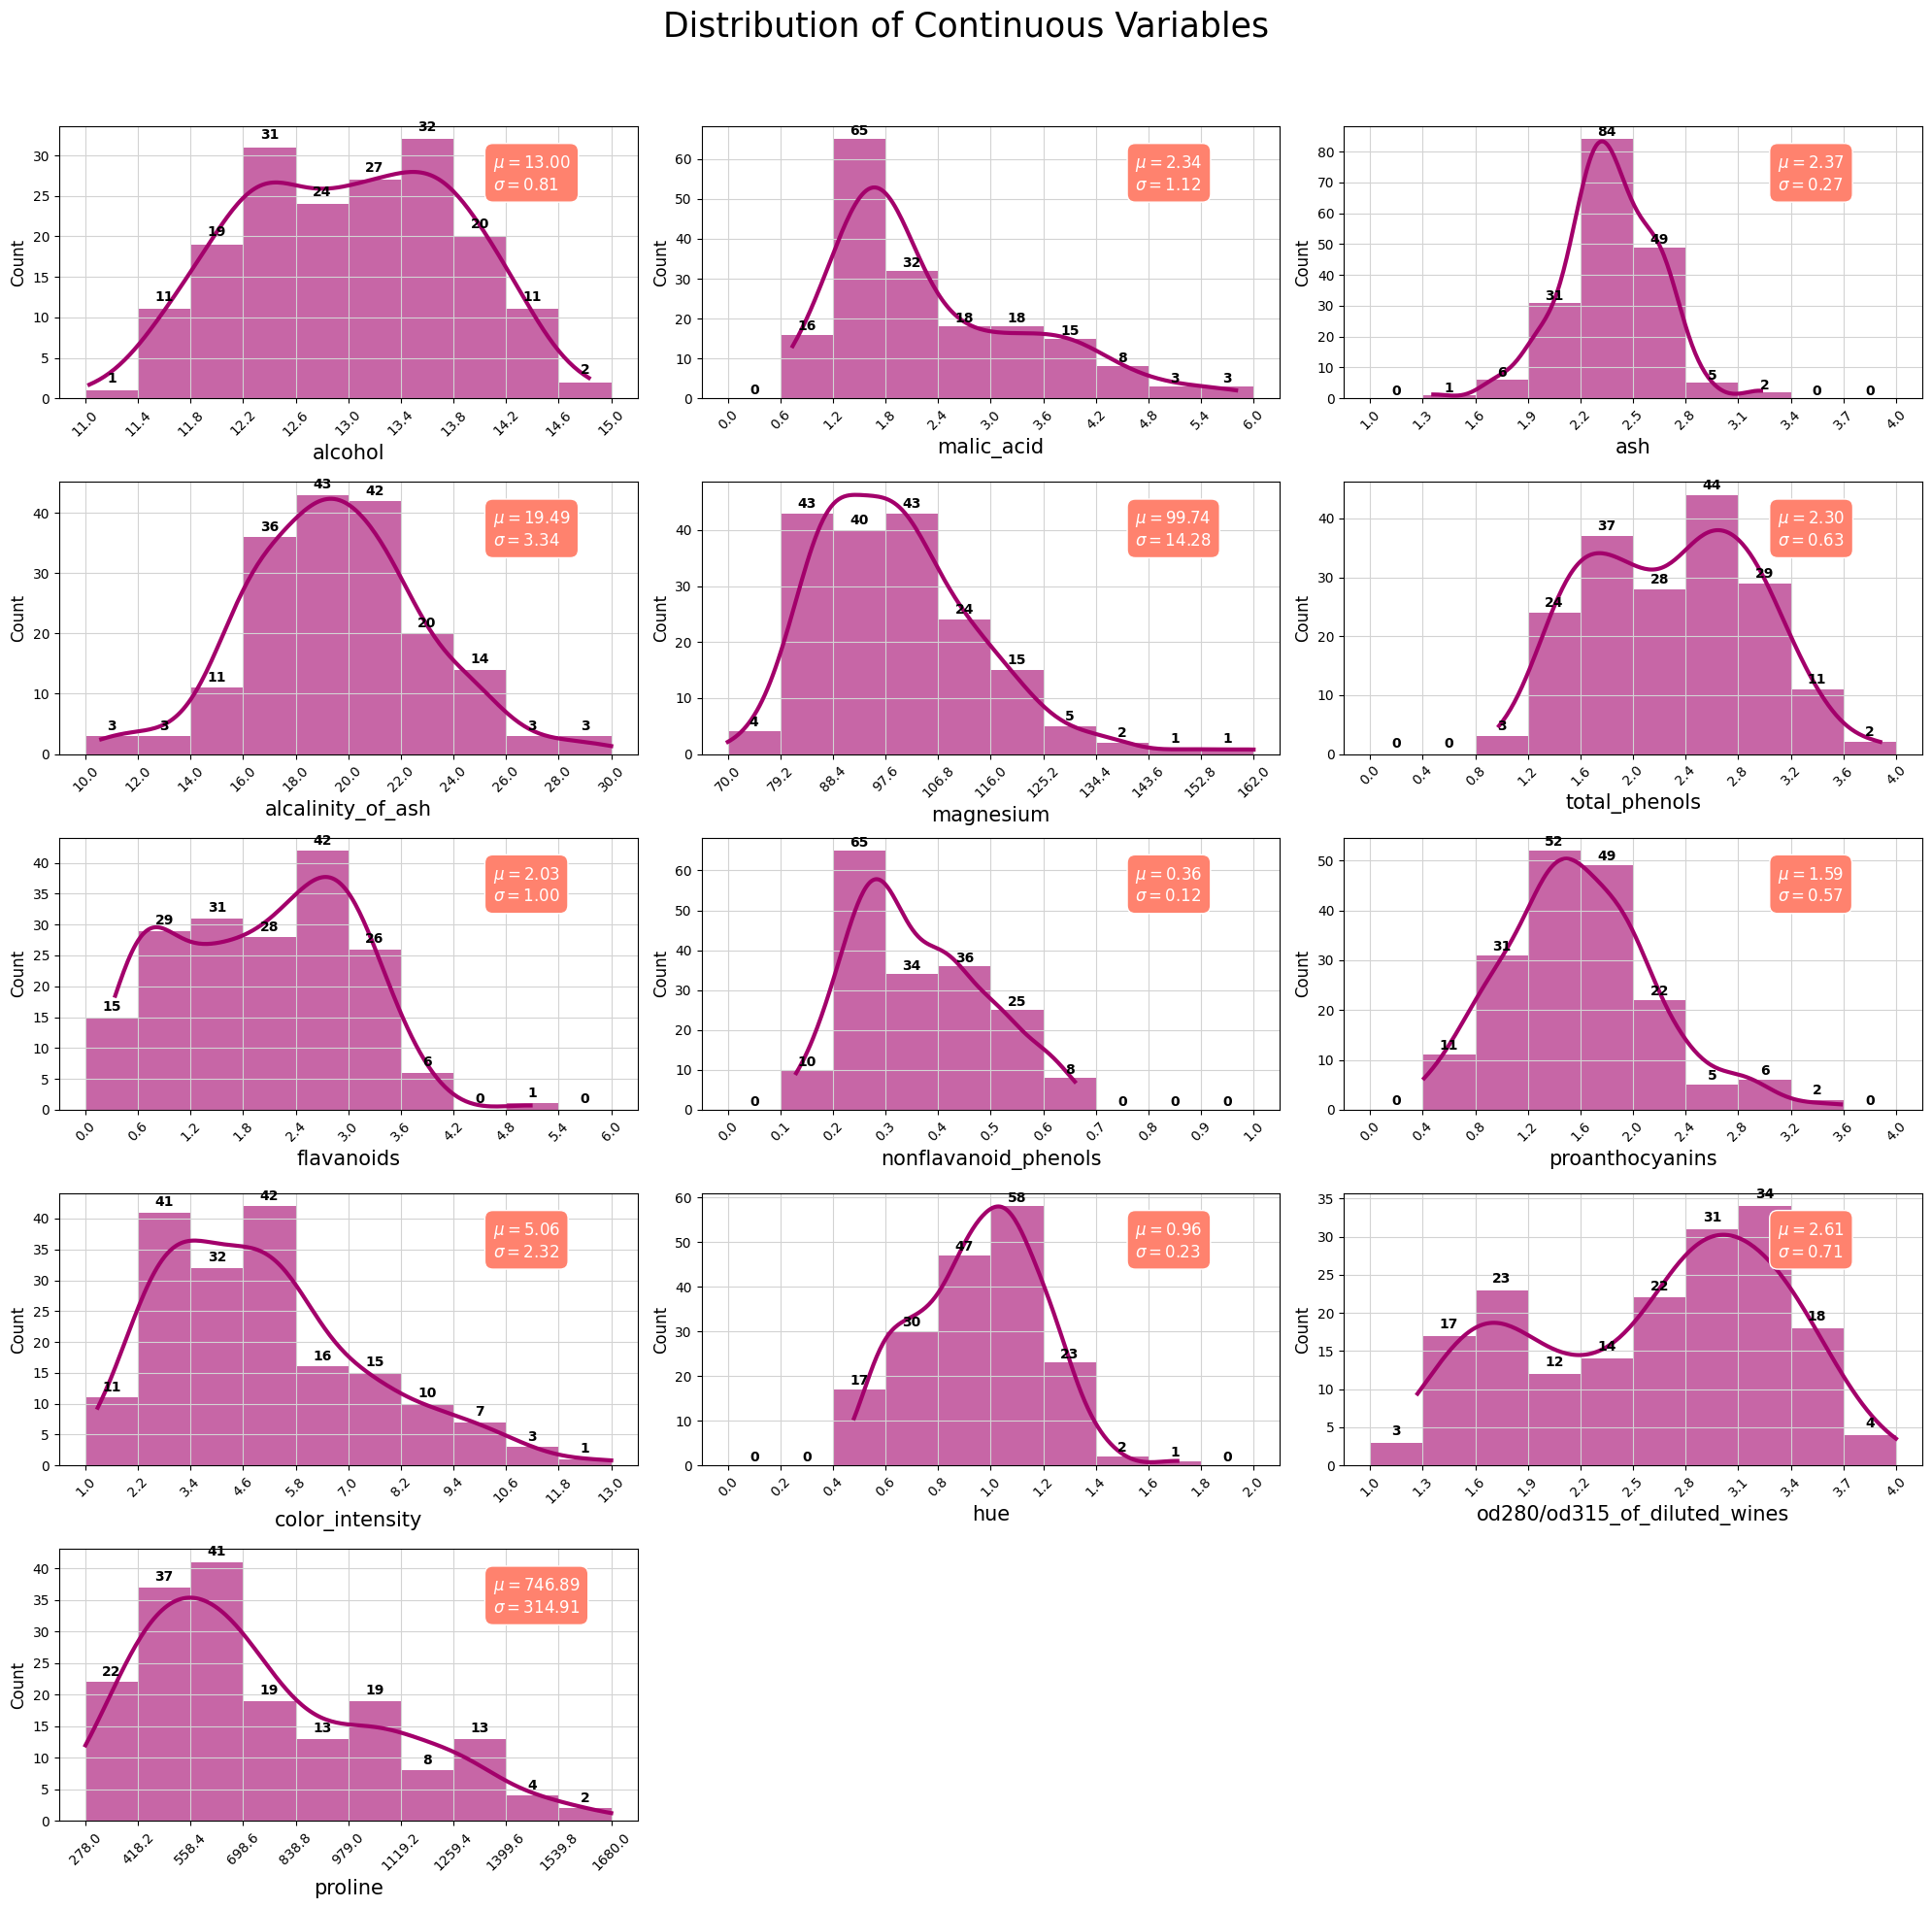

In [21]:
# Set up the subplot
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(df_continuous[col], 
                                     range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))
    
    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='#a3006b', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')
    
    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

ax[4,1].axis('off')
ax[4,2].axis('off')
plt.suptitle('Distribution of Continuous Variables', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

<div style="background-color: #bca89f;  padding: 20px; border-radius: 10px;">
  <h2 style="text-align: center;">🍷 Inference 🍷</h2> 
  <p><strong>Alcohol Content:</strong> The alcohol content in the wine samples ranges from approximately 11.0% to 15.0%. The mean alcohol content is 13.00% with a standard deviation of 0.81. This suggests that most wines have an alcohol content around 13.00%, with a moderate spread. This information can be useful for winemakers and marketers to understand the typical alcohol content in their wines and how it compares to the industry standard. If their wines have significantly higher or lower alcohol content, it could be a unique selling point or a potential area for improvement.</p>
  
  <p><strong>Alkalinity of Ash:</strong> The alkalinity of ash in the wine samples ranges from approximately 10.0 to 30.0, with a mean of 19.49 and a standard deviation of 3.34. This indicates a wider spread around the mean compared to the alcohol content. Alkalinity of ash is a measure of the wine's ability to neutralize acids, which can affect the taste and quality of the wine. Understanding this distribution can help winemakers optimize the alkalinity of ash in their wines to achieve the desired taste and quality.</p>
  
  <p><strong>Malic Acid:</strong> The mean malic acid content is 2.34 with a standard deviation of 1.12. The distribution is right-skewed, indicating that most wines have a malic acid content less than the mean, but there are some wines with significantly higher malic acid content. Malic acid contributes to the sour taste in wines, so understanding its distribution can help winemakers balance the taste of their wines.</p>
  
  <p><strong>Ash:</strong> The mean ash content is 2.37 with a standard deviation of 0.27. The distribution is approximately normal, suggesting that the ash content in most wines is close to the mean. Ash content is related to the mineral content of the wine, which can affect the taste and quality of the wine.</p>
  
  <p><strong>Magnesium:</strong> The mean magnesium content is 99.74 with a standard deviation of 14.28. The distribution is roughly symmetric with a slight right skew. Magnesium is an important mineral in wine that can affect the health benefits of the wine.</p>
  
  <p><strong>Total Phenols:</strong> The mean total phenols content is 2.30 with a standard deviation of 0.63. The distribution shows a slight left skew, indicating that most wines have a total phenols content higher than the mean. Phenols in wine contribute to the taste and are also associated with antioxidant properties.</p>
  
  <p><strong>Nonflavonoid Phenols:</strong> The mean nonflavonoid phenols content is 0.36 with a standard deviation of 0.12. The distribution is right-skewed, indicating that most wines have a nonflavonoid phenols content less than the mean, but there are some wines with significantly higher nonflavonoid phenols content. Nonflavonoid phenols contribute to the bitterness of the wine, so understanding its distribution can help winemakers balance the taste of their wines.</p>
  
  <p><strong>Proanthocyanins:</strong> The mean proanthocyanins content is 1.59 with a standard deviation of 0.57. The distribution is right-skewed, indicating that most wines have a proanthocyanins content less than the mean, but there are some wines with significantly higher proanthocyanins content. Proanthocyanins are a type of flavonoid that can affect the color and taste of the wine. Understanding its distribution can help winemakers optimize the color and taste of their wines.</p>
  
  <p><strong>Hue:</strong> The mean hue is 0.96 with a standard deviation of 0.23. The distribution is approximately normal, suggesting that the hue in most wines is close to the mean. Hue can affect the visual appeal of the wine, so understanding its distribution can help winemakers and marketers make informed decisions.</p>
  
  <p><strong>od280/od315_of_diluted_wines:</strong> The mean od280/od315_of_diluted_wines is 2.61 with a standard deviation of 0.71. The distribution is left-skewed, indicating that most wines have an od280/od315_of_diluted_wines value higher than the mean. This feature is a measure of wine dilution and can affect the taste and quality of the wine. Understanding its distribution can help winemakers optimize the dilution of their wines.</p>
  
  <p><strong>Flavonoids:</strong> The mean flavonoids content is 2.03 with a standard deviation of 1.00. The distribution is approximately normal, suggesting that the flavonoids content in most wines is close to the mean. Flavonoids are a type of antioxidant and contribute to the taste and color of the wine. Understanding its distribution can help winemakers balance the taste and color of their wines.</p>
  
  <p><strong>Color Intensity:</strong> The mean color intensity is 5.06 with a standard deviation of 2.32. The distribution is right-skewed, indicating that most wines have a color intensity less than the mean, but there are some wines with significantly higher color intensity. The color intensity of a wine can affect its appeal to consumers, so understanding its distribution can help winemakers and marketers make informed decisions.</p>
  
  <p><strong>Proline:</strong> The mean proline content is 746.89 with a standard deviation of 314.91. The distribution is right-skewed, indicating that most wines have a proline content less than the mean, but there are some wines with significantly higher proline content. Proline is an amino acid that can contribute to the taste and texture of the wine. Understanding its distribution can help winemakers optimize the taste and texture of their wines.</p>
</div>


# 5 | Bivariate Analysis

<a id="5"></a>
 ⬆️[Table Contents](#table_content)

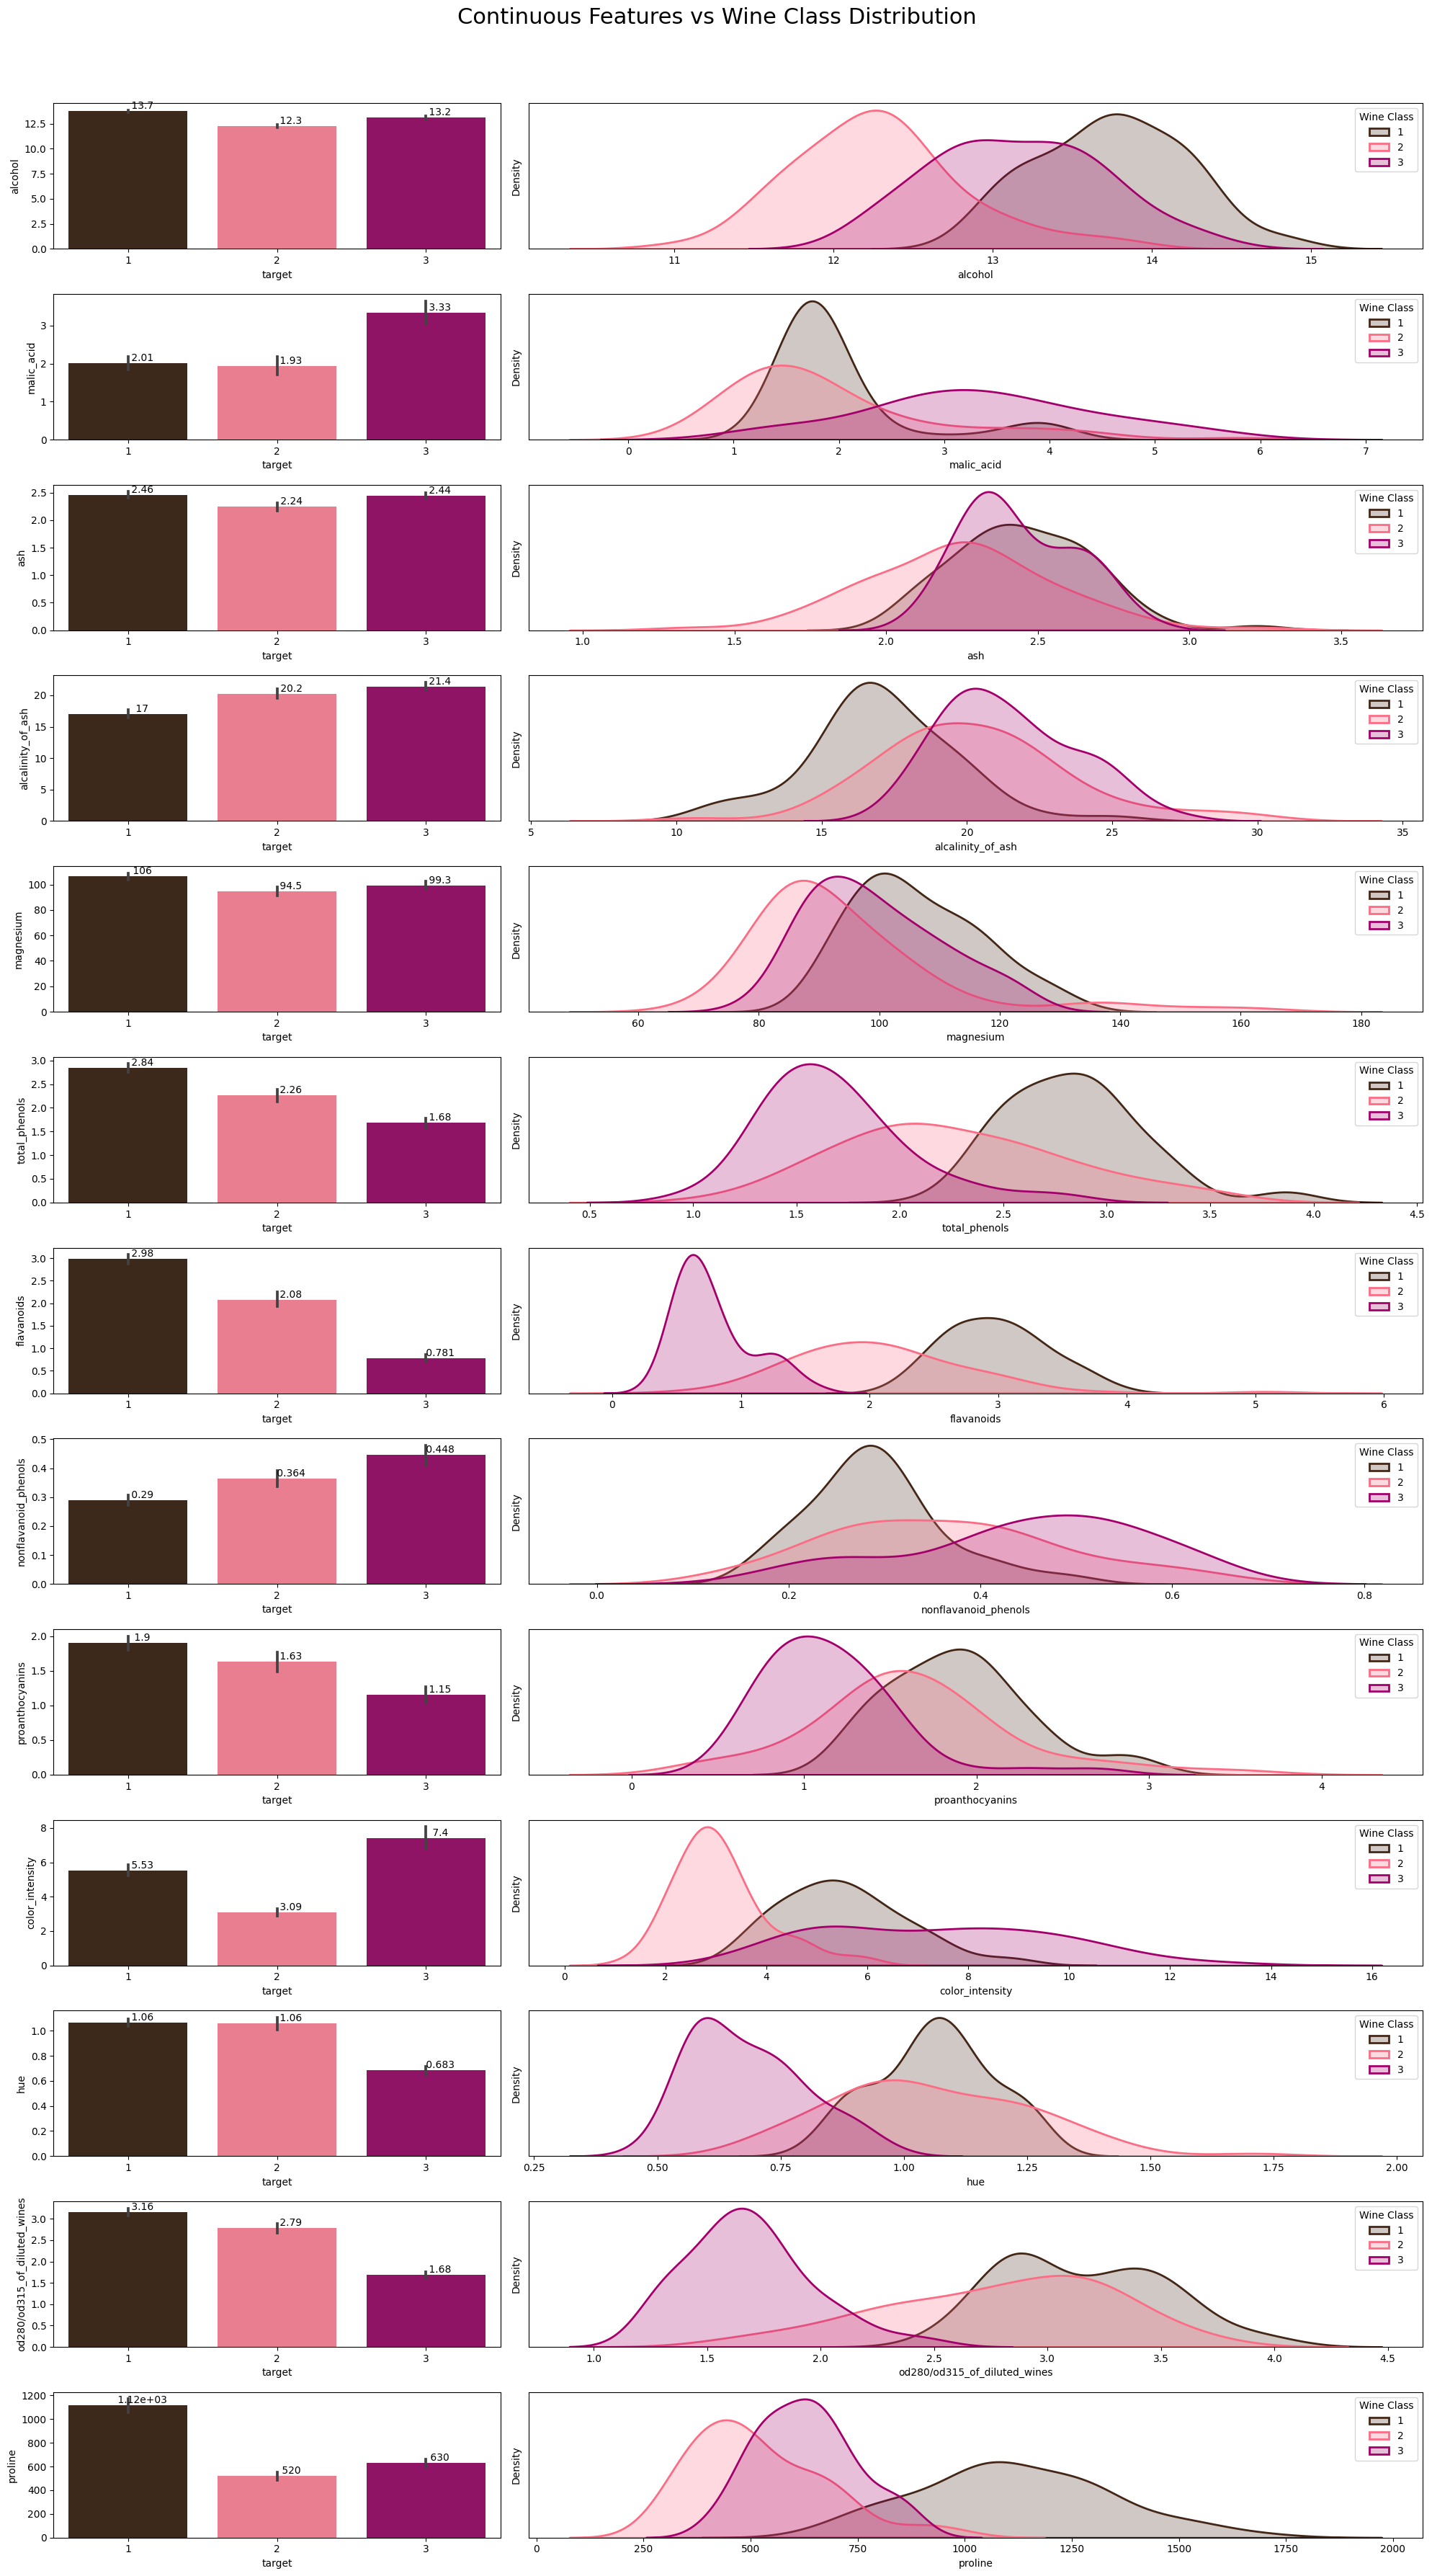

In [23]:
# Set color palette related to wine
sns.set_palette(['#432616','#FC6C85', '#a3006b'])

# Create the subplots
fig, ax = plt.subplots(len(cont_cols), 2, figsize=(20,35), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col in enumerate(cont_cols):
    # Barplot showing the mean value of the feature for each target category
    graph = sns.barplot(data=wine_df, x="target", y=col, ax=ax[i,0])
    
    # KDE plot showing the distribution of the feature for each target category
    sns.kdeplot(data=wine_df[wine_df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    sns.kdeplot(data=wine_df[wine_df["target"]==2], x=col, fill=True, linewidth=2, ax=ax[i,1], label='2')
    sns.kdeplot(data=wine_df[wine_df["target"]==3], x=col, fill=True, linewidth=2, ax=ax[i,1], label='3')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Wine Class', loc='upper right')
    
    # Add mean values to the barplot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
# Set the title for the entire figure
plt.suptitle('Continuous Features vs Wine Class Distribution', fontsize=22,y=1.02)
plt.tight_layout()                     
plt.show()


# 6 | Data Preprocessing
<a id="6"></a>
 ⬆️[Table Contents](#table_content)

## 6.1 |  Missing Value Treatment
<a id="6.1"></a>

In [25]:
wine_df.isnull().sum().sum()

0

## 6.2 | Duplicate Values Treatment
<a id="6.2"></a>

In [28]:
wine_df.duplicated().sum()

0

## 6.3 | Outlier Treatment
<a id="6.3"></a>

In [29]:
Q1 = wine_df[cont_cols].quantile(0.25)
Q3 = wine_df[cont_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = (((wine_df[cont_cols] < (Q1 - 1.5 * IQR)) | (wine_df[cont_cols] > (Q3 + 1.5 * IQR))).sum())/len(wine_df)

In [32]:
print("Outlier Ratio's:\n",outliers_count_specified)

Outlier Ratio's:
 alcohol                         0.000000
malic_acid                      0.016854
ash                             0.016854
alcalinity_of_ash               0.022472
magnesium                       0.022472
total_phenols                   0.000000
flavanoids                      0.000000
nonflavanoid_phenols            0.000000
proanthocyanins                 0.011236
color_intensity                 0.022472
hue                             0.005618
od280/od315_of_diluted_wines    0.000000
proline                         0.000000
dtype: float64


<div style="background-color: #bca89f;  padding: 20px; border-radius: 10px;">
  <h2 style="text-align: center;">🍷 Inference 🍷</h2> 
    <p>No significant treatment needed as the outlier ratios are <b>less than 5%</b>.</p>

## 6.4 | Split out training and testing datasets
<a id="6.4"></a>

In [33]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(wine_df, test_size=0.1, random_state=42)

print(train_df.shape, test_df.shape)
train_df.head()

(160, 14) (18, 14)


,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045
114,2,12.08,1.39,2.50,22.5,84,2.56,2.29,0.43,1.04,2.90,0.93,3.19,385
18,1,14.19,1.59,2.48,16.5,108,3.30,3.93,0.32,1.86,8.70,1.23,2.82,1680
66,2,13.11,1.01,1.70,15.0,78,2.98,3.18,0.26,2.28,5.30,1.12,3.18,502
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680


In [35]:
# Create a big dataset to test out batch inference later
big_test_df = test_df.sample(500_000, replace=True, ignore_index=True)

print(big_test_df.shape)
big_test_df.head()

(500000, 14)


,target,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1,13.73,1.50,2.70,22.5,101,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285
1,1,13.50,1.81,2.61,20.0,96,2.53,2.61,0.28,1.66,3.52,1.12,3.82,845
2,3,13.36,2.56,2.35,20.0,89,1.40,0.50,0.37,0.64,5.60,0.70,2.47,780
3,2,12.00,3.43,2.00,19.0,87,2.00,1.64,0.37,1.87,1.28,0.93,3.05,564
4,1,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.20,1.07,2.65,1280


## 6.5 | Write the training and testing datasets to S3
<a id="6.5"></a>

In [ ]:
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()

print(bucket)

In [ ]:
# Write the files locally
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)
big_test_df.to_json("../data/bigtest.json", orient="records", lines=True)

In [ ]:
# Send the files to S3
train_path = session.upload_data(
    path="../data/train.csv", bucket=bucket, key_prefix="sagemaker/wine_class"
)

test_path = session.upload_data(
    path="../data/test.csv", bucket=bucket, key_prefix="sagemaker/wine_class"
)

bigtest_path = session.upload_data(
    path="../data/bigtest.json", bucket=bucket, key_prefix="sagemaker/wine_class"
)

print(f"Train path: {train_path}")
print(f"Test path: {test_path}")
print(f"Big Test path: {bigtest_path}")

# 7 | Model Deployement Process
<a id="7"></a>
 ⬆️[Table Contents](#table_content)

## 7.1 | Fit the Pipeline
<a id="7.1"></a>

In [ ]:
%%writefile train.py

import argparse
import os
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model_file_name = "pipeline_model.joblib"

# Main function
def main():
    # Arguments
    parser = argparse.ArgumentParser()
    
    # Inbuilt Arguments: https://github.com/aws/sagemaker-containers#id11
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    
    # Custom Arguments
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--min_samples_split", type=float, default=0.05)
    parser.add_argument("--criterion", type=str, default="gini")
    
    args, _ = parser.parse_known_args()
    
    
    # Load data
    train_df = pd.read_csv(train_path) # TODO: Paste the S3 path to your train.csv
    test_df = pd.read_csv(test_path) # TODO: Paste the S3 path to your test.csv

    # Define the columns
    cat_cols = list(train_df.describe(include="object").columns)
    cont_cols = list(train_df.drop(columns='target').describe().columns)

    # Split X(features) and y(response)
    X_train = train_df.drop("target", axis=1)
    y_train = train_df["target"]

    X_test = test_df.drop("target", axis=1)
    y_test = test_df["target"]

    # One hot encode the categorical columns
    ohe = OneHotEncoder(drop="first")

    # Scale the continuous columns
    sc = StandardScaler()

    # Column transformer to apply transformations on both categorical and continuous columns
    ct = ColumnTransformer([
        ("One Hot Encoding", ohe, cat_cols),
        ("Scaling", sc, cont_cols)
    ])
    
    # Random Forest Model
    rfc = RandomForestClassifier(n_estimators=args.n_estimators, 
                                 min_samples_split=args.min_samples_split,
                                 criterion=args.criterion)

    # Sklearn pipeline
    pipeline_rfc_model = Pipeline([
        ("Data Transformations", ct),
        ("Random Forest Model", rfc)
        
    ])

    # Fit the model locally on a smaller subset of data
    pipeline_rfc_model.fit(X_train, y_train)

    # Check the accuracy on training data
    train_accuracy = pipeline_rfc_model.score(X_train, y_train)
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Check the accuracy on test data
    test_accuracy = pipeline_rfc_model.score(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy:.4f}")

    # Save the model
    model_save_path = os.path.join(args.model_dir, model_file_name)
    joblib.dump(pipeline_rfc_model, model_save_path)
    print(f"Model saved at {model_save_path}")

# Run the main function when the script runs
if __name__ == "__main__":
    main()


In [ ]:
%%writefile requirements.txt
pandas
scikit-learn
fsspec
s3fs

In [ ]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

sklearn_estimator = SKLearn(
    base_job_name="rfc-pipeline-run",
    framework_version="1.0-1",
    entry_point="train.py",
    dependencies=["requirements.txt"],
    hyperparameters={
        "n_estimators": 50,
        "min_samples_split": 0.05,
        "criterion": "gini"
    },
    instance_count=1,
    instance_type="ml.m5.large",
    use_spot_instances=True,
    max_wait=600,
    max_run=600,
    role=get_execution_role(),
)

# Launch Training job
sklearn_estimator.fit()

## 7.2 | Check the training job name
<a id="7.2"></a>

In [ ]:
import boto3
sm_client = boto3.client("sagemaker")

training_job_name = sklearn_estimator.latest_training_job.name

# Obtain the location of the model stored on S3 - Optional
# You can directly copy the location of the artifact from S3 also!
model_artifact = sm_client.describe_training_job(
    TrainingJobName=training_job_name
)["ModelArtifacts"]["S3ModelArtifacts"]

print(f"Training job name: {training_job_name}")
print(f"Model storage location: {model_artifact}")

## 7.3 | Hyperparameter Tuning
<a id="7.3"></a>

In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter, CategoricalParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "n_estimators": IntegerParameter(1, 20),
    "min_samples_split": ContinuousParameter(0.01, 0.5),
    "criterion": CategoricalParameter(["gini", "entropy"])
}

# Create optimizer
optimizer = HyperparameterTuner(
    base_tuning_job_name="rfc-pipeline-tuner",
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type="Maximize",
    objective_metric_name="test-accuracy",
    metric_definitions=[
        {"Name": "train-accuracy", "Regex": "Training Accuracy: ([0-9.]+).*$"},
        {"Name": "test-accuracy", "Regex": "Testing Accuracy: ([0-9.]+).*$"}
    ],
    max_jobs=10,
    max_parallel_jobs=2,
)

# Launch Optimizer job
optimizer.fit()

In [ ]:
# Analyse tuning results
results = optimizer.analytics().dataframe()

results.sort_values("FinalObjectiveValue", ascending=False).head()

# 8 | Serverless Deployment
<a id="8"></a>
 ⬆️[Table Contents](#table_content)

In [ ]:
%%writefile serve.py

import os
import joblib
import pandas as pd

def model_fn(model_dir):
    """Load and return the model"""
    model_file_name = "pipeline_model.joblib"
    pipeline_model = joblib.load(os.path.join(model_dir, model_file_name))
    
    return pipeline_model

def input_fn(request_body, request_content_type):
    """Process the input json data and return the processed data.
    you can also add any input data pre-processing in this function"""
    if request_content_type == "application/json":
        input_object = pd.read_json(request_body, lines=True)
        
        return input_object
    else:
        raise ValueError("Only application/json content type supported!")

def predict_fn(input_object, pipeline_model):
    """Make predictions on processed input data"""
    predictions = pipeline_model.predict(input_data)
    pred_probs = pipeline_model.predict_proba(input_object)
    
    prediction_object = pd.DataFrame(
        {
            "prediction": predictions.tolist(),
            "pred_prob_class0": pred_probs[:, 0].tolist(),
            "pred_prob_class1": pred_probs[:, 1].tolist()
        }
    )
    
    return prediction_object

def output_fn(prediction_object, request_content_type):
    """Post process the predictions and return as json"""
    return_object = prediction_object.to_json(orient="records", lines=True)
    
    return return_object
    
    

In [ ]:
# Create the deployment
from sagemaker.sklearn.model import SKLearnModel
from sagemaker import Session, get_execution_role

session = Session()
bucket = session.default_bucket()

training_job_name = "..." # TODO: Update with best TrainingJobName from hyperparameter tuning
model_artifact = f"s3://{bucket}/{training_job_name}/output/model.tar.gz"
endpoint_name = "salary-predict-rfc-pipeline-real-time"

model = SKLearnModel(
    name=endpoint_name,
    framework_version="1.0-1",
    entry_point="serve.py",
    dependencies=["requirements.txt"],
    model_data=model_artifact,
    role=get_execution_role(),
)

In [ ]:
# Create a config for serverless inference
from sagemaker.serverless import ServerlessInferenceConfig
serverless_config = ServerlessInferenceConfig(memory_size_in_mb=1024, max_concurrency=4)

In [ ]:
# Deploy!
predictor = model.deploy(serverless_inference_config=serverless_config)

In [ ]:
endpoint_name = predictor.endpoint_name
print("Endpoint name:")
print(f"{endpoint_name}")

## 8.1 | Invoke the model
<a id="8.1"></a>

In [ ]:

import pandas as pd

test_df = pd.read_csv(test_path) # TODO: Paste the S3 path to your test.csv

X_test = test_df.drop("target", axis=1)
y_test = test_df["target"]

# Get two rows to make predictions on
X_pred = X_test.head(2).to_json(orient="records", lines=True)
X_pred

In [ ]:
# Submit to the endpoint
import boto3

sm_runtime = boto3.client("sagemaker-runtime")

response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                      Body=X_pred, 
                                      ContentType="application/json", 
                                      Accept="application/json")

In [ ]:
# Decode the response from the endpoint
response_body = response['Body']
response_str = response_body.read().decode('utf-8')
response_df = pd.read_json(response_str, lines=True)

response_df

## 8.2 | Cleanup
<a id="8.2"></a>

In [ ]:
import boto3

def cleanup(endpoint_name):
    sm_client = boto3.client("sagemaker")

    # Get the model name from endpoint_name
    response = sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)

    # Delete the endpoint
    sm_client.delete_endpoint(EndpointName=endpoint_name)

    # Delete the endpoint config
    endpoint_config_name = response['EndpointConfigName']
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)                        

    # Delete the model
    model_name = response['ProductionVariants'][0]['ModelName']
    sm_client.delete_model(ModelName=model_name)

In [ ]:
# Run the cleanup
cleanup(endpoint_name)